<a href="https://colab.research.google.com/github/hamiin47/OB-session/blob/main/Assign_0523.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5.3 전이 학습**

전이 학습 : 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치르 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것

-> 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 훈련된 모델(네트워크)이라고 한다.

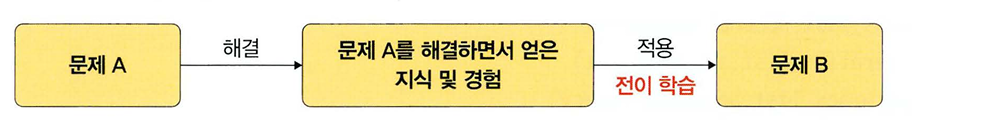

# 5.3.1 특성 추출 기법

- 특성 추출은 이미지넷 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만든다.

  ➡️ 즉, 학습할 때는 마지막 완전연결층만 학습하고 나머지 계층들은 학습되지 않도록 한다

- 특성 추출은 이미지 분류를 위해 합성곱층과 데이터분류기로 구성된다.
  - 합성곱층 : 합성곱층과 풀링층으로 구성
  - 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

- 사전 훈련된 네트워크의 합성곱층에 새로운 데이터를 통과시키고 그 출력을 데이터 분류기에서 훈련시킨다
  - 사용 가능 이미지 분류 모델 : Xception / Inception V3 / ResNet50 / VGG16 / VGG19 / MobileNet

  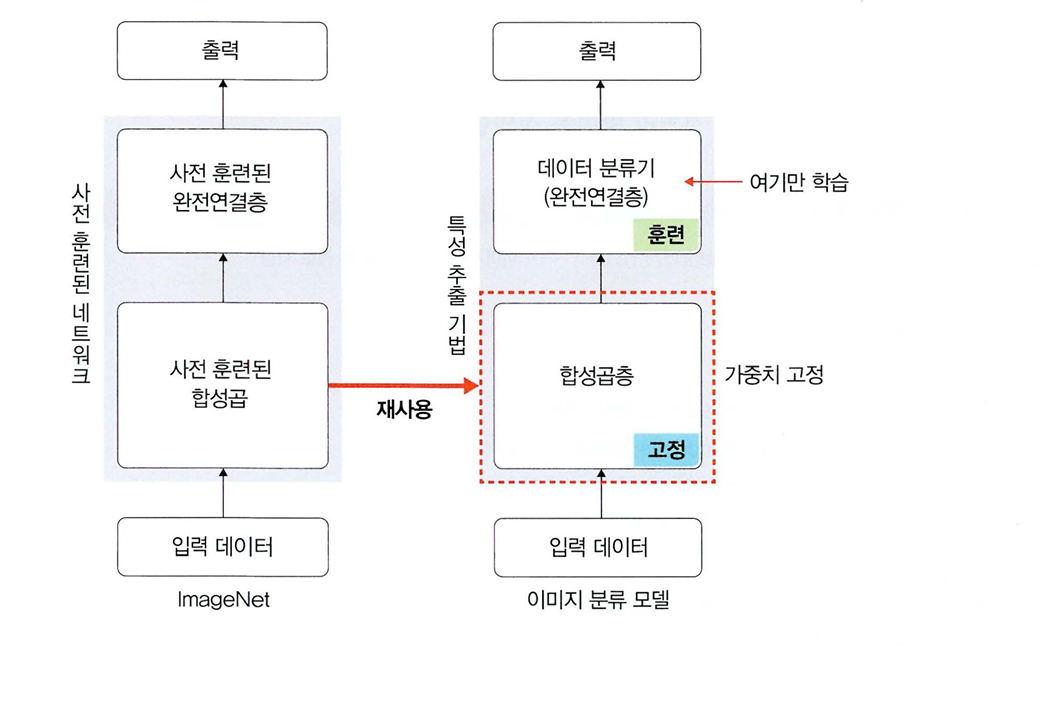

In [1]:
! pip install opencv-python

In [2]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2   # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision   # 컴퓨터 비전(computer vision) 용도의 패키지
import torchvision.transforms as transforms   # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models   # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap05/data/catanddog/

# 3. 파일 목록 확인
!ls

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.
/content/080289/chap05/data/catanddog
test  train


In [4]:
# 이미지 데이터 전처리 방법 정의
data_path = '/content/080289/chap05/data/catanddog/train'   # 이미지 데이터가 위치한 경로 지정

transform=transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])   # ①
train_dataset = torchvision.datasets.ImageFolder(
                data_path,
                transform=transform
)    # ②
train_loader = torch.utils.data.DataLoader(
               train_dataset,
               batch_size=32,
               num_workers=8,
               shuffle=True
)    # ③

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


① torchvision.transform은 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환해준다.

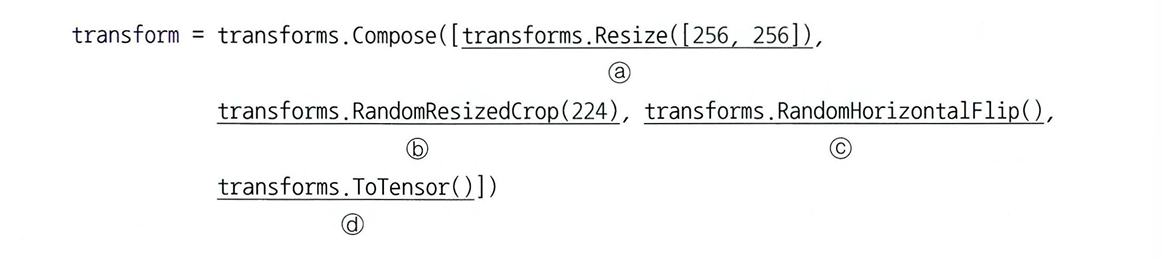

  a. Resize : 이미지의 크기를 조정

  b. RandomResizedCrop : 이미지를 랜덤함 크기 및 비율로 자른다
  
  → Resize는 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정이라면,RandomResizedCrop는 데이터 확장 용도로 사용된다.

  c. RandomHorizontalFlip : 이미지를 랜덤하게 수평으로 뒤집는다

  d. ToTensor : 이미지 데이터를 텐서로 변환한다


---




② datasets.ImageFolder는 데이터로더가 데이터를 불러올 대상(혹은 경로)과 방법(혹은 전처리)을 의미한다

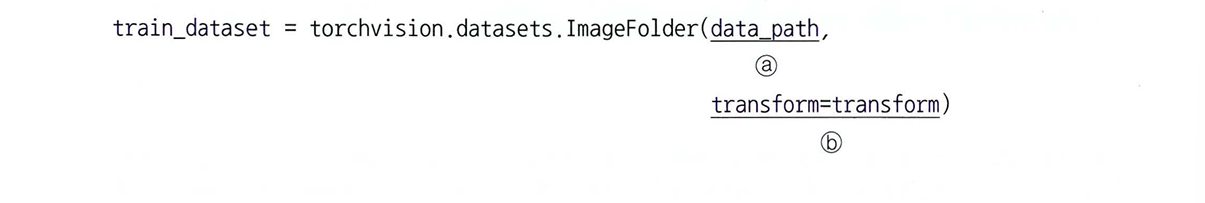

a. 첫번째 파라미터 : 불러올 데이터가 위치한 경로

b. transform : 이미지 데이터에 대한 전처리


---



③ 데이터로더는 데이터를 불러오는 부분으로 앞에서 정의한 ImageFolder(train_dataset)을 데이터로더에 할당하는데, 이때 한번에 불러올 데이터양을 결정하는 batch_size와 추가적으로 데이터를 무작위로 섞을 것인지 설정한다.

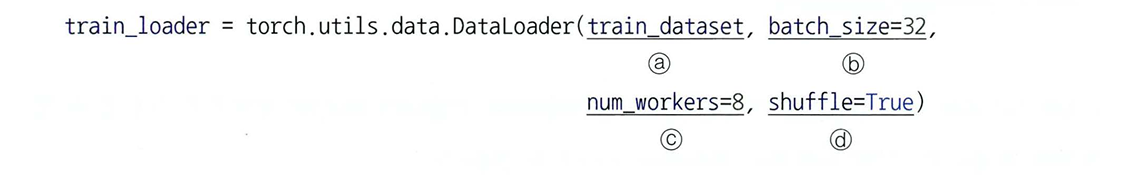

a. 첫 번째 파라미터 : 데이터셋을 지정한다.

b. batch_size : 한 번에 불러올 데이터양을 결정하는 배치 크기를 설정한다

c. num_workers : 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정 → 너무 많은 하위 프로세스를 설정하게 되면 오류가 발생하거나 메모리 부족 현상이 발생하기도 함

d. shuffle : 데이터를 무작위로 섞을지를 지정한다. shuffle = True로 설정하면 데이터를 무작위로 섞어서 랜덤으로 불러온다

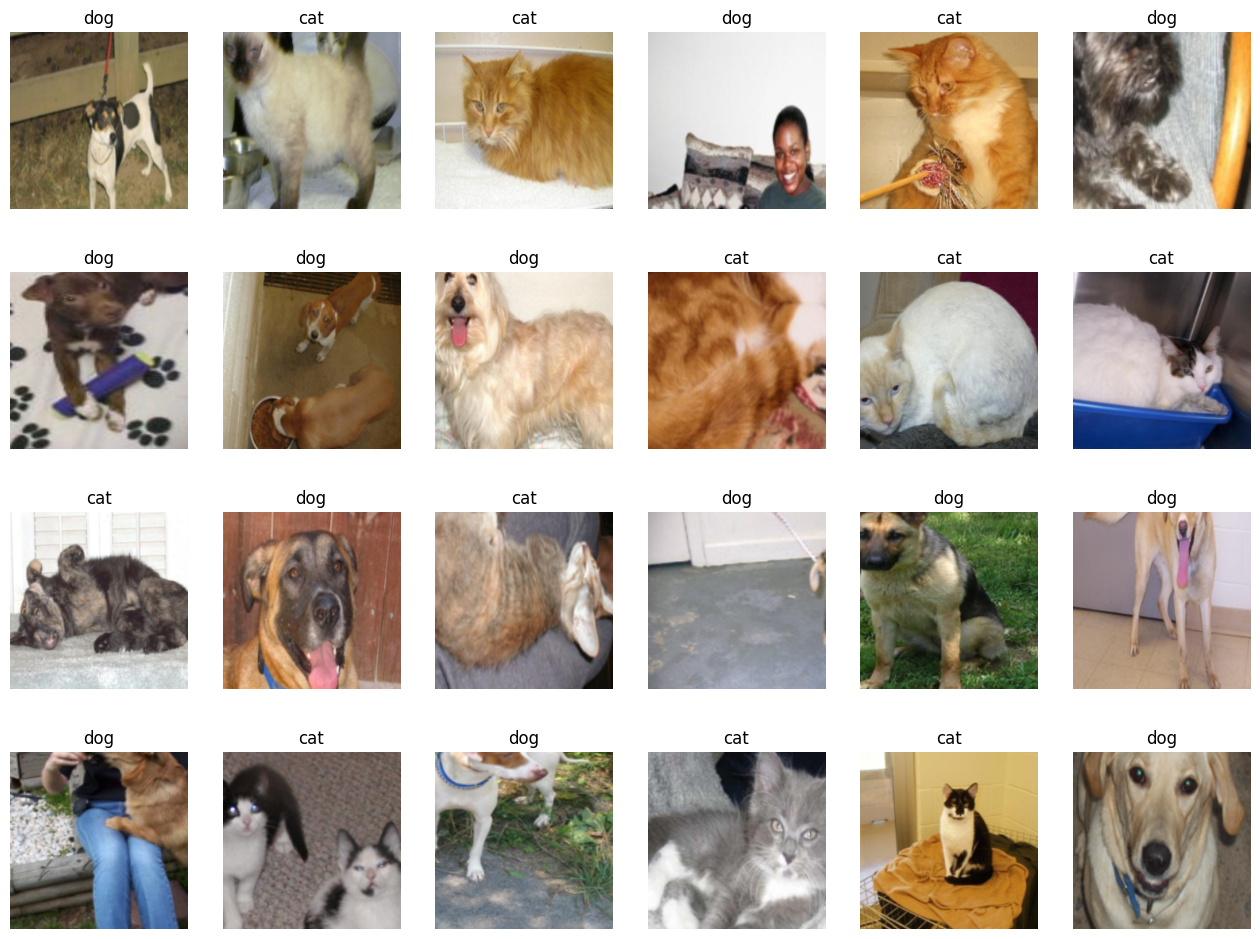

In [5]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader))   # ①
classes = {0:'cat', 1:'dog'}   # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16, 24))
for i in range(24):   # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])   # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))   # ②
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

① 반복자를 사용하려면 iter()와 next()가 필요하다
  - iter()는 전달된 데이터의 반복자를 꺼내 반환
  - next()는 그 반복자가 다음에 출력할 요소 반환

② np.transpose는 행과 열을 바꿈으로써 행렬의 차원을 바꾸어준다.

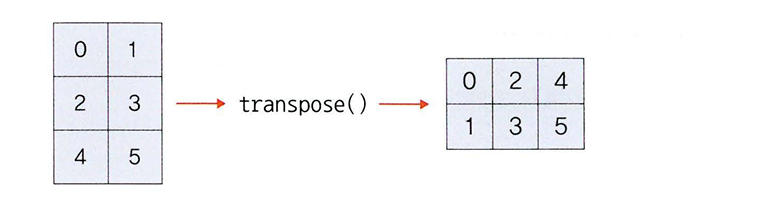



---



- 행렬의 차원을 변경하는 이유는 행렬의 내적 연산 때문이다.

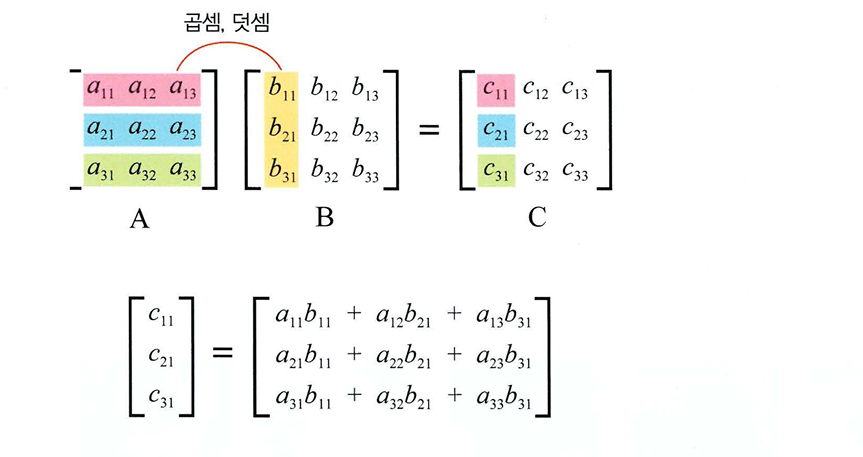

  - A라는 행렬과 B라는 행렬의 내적 결과는 C가 된다. (* A행렬의 행과 B행렬의 열의 수가 같아야 내적이 가능하다)
  - A와 B의 행과 열의 수가 달라 내적이 불가능할 때는 np.transpose()나 np.reshape() 등으로 차원을 조정해야한다.

In [6]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True) #pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


In [7]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False   # ①

set_parameter_requires_grad(resnet18, feature_extracting=True)

① 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음을 의미한다.

In [8]:
# ResNet18에 완전연결층 추가
#추가된 완전연결층은 개와 고양이 클래스를 분류하는 용도로 사용된다.
resnet18.fc = nn.Linear(512, 2)   # 2는 클래스가 두 개라는 의미

In [9]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():   # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
       print(name, param.data)

fc.weight tensor([[-0.0154,  0.0024,  0.0354,  ..., -0.0085,  0.0083, -0.0360],
        [ 0.0081, -0.0053, -0.0118,  ...,  0.0046, -0.0007, -0.0192]])
fc.bias tensor([ 0.0197, -0.0271])


In [10]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)   # 모델의 객체 생성

for param in model.parameters():   # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():   # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
cost = torch.nn.CrossEntropyLoss()   # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
    since = time.time()   # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0
    model.to(device)

    for epoch in range(num_epochs):   # 에포크(13)만큼 반복
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:   # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()   # 기울기 0으로 설정
            outputs = model(inputs)   # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()   # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)   # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)   # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset)   # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)   # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/',
                   '{0:0=2d}.pth'.format(epoch)))   # 모델 재사용을 위해 저장해 둡니다.
        print()

    time_elapsed = time.time() - since    # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))
    return acc_history, loss_history    # 모델의 정확도와 오차를 반환

In [12]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)   # 파라미터 학습 결과를 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update)   # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [13]:
# 모델 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()   # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------
Loss: 0.7013 Acc: 0.5636

Epoch 1/12
----------
Loss: 0.4969 Acc: 0.7455

Epoch 2/12
----------
Loss: 0.4280 Acc: 0.8026

Epoch 3/12
----------
Loss: 0.3333 Acc: 0.8442

Epoch 4/12
----------
Loss: 0.2625 Acc: 0.9091

Epoch 5/12
----------
Loss: 0.2534 Acc: 0.8961

Epoch 6/12
----------
Loss: 0.2325 Acc: 0.9169

Epoch 7/12
----------
Loss: 0.2943 Acc: 0.8545

Epoch 8/12
----------
Loss: 0.2083 Acc: 0.9247

Epoch 9/12
----------
Loss: 0.2480 Acc: 0.8857

Epoch 10/12
----------
Loss: 0.2612 Acc: 0.8805

Epoch 11/12
----------
Loss: 0.2367 Acc: 0.8857

Epoch 12/12
----------
Loss: 0.1787 Acc: 0.9377

Training complete in 9m 18s
Best Acc: 0.9377


In [14]:
# 테스트 데이터 호출 및 전처리
test_path = '/content/080289/chap05/data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [15]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth')   # ①
    saved_models.sort()   # 불러온 .pth 파일들을 정렬
    print('saved_model:', saved_models)

    for model_path in saved_models:
        print('loading model:', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in test_loader:   # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():   # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)   # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)   # ②
            preds[preds > 0.5] = 1    # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds <= 0.5] = 0   # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.data.view_as(preds)).sum().item()   # ③

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)   # 테스트 데이터의 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
           best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                          time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history   # 계산된 정확도 반환

① glob는 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용한다.

② torch.max는 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환하는 함수이다.

③ preds.eq(labels)는 preds 배열과 labels가 일치하는지 검사하는 용도로 사용한다.

In [16]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model: []
Validation complete in 0m 0s
Best Acc: 0.0000


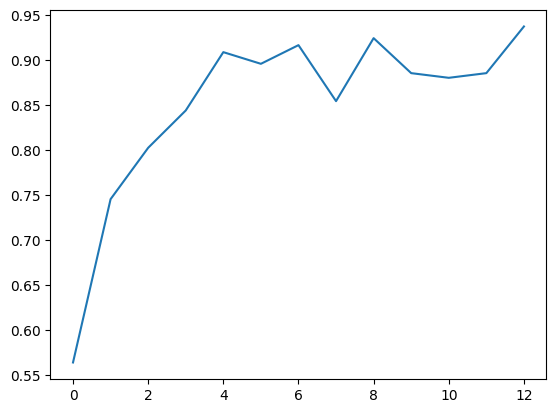

In [17]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

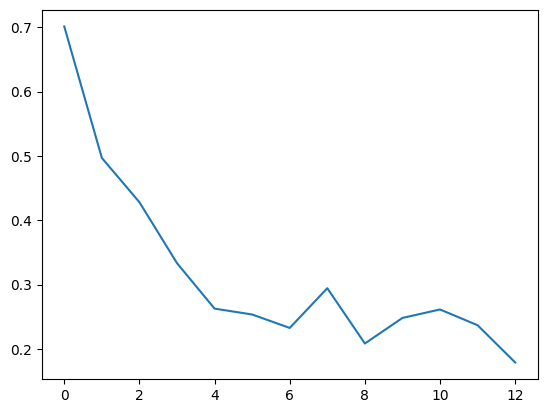

In [18]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [19]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()   # ①
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)   # ②
    return image

① tensor.clone()은 기존 텐서의 내용을 복사한 텐서를 생성하겠다는 의미이며, detach()는 기존 텐서에서 기울기가 전파되지 않는 텐서이다.

  → tensor.clone().detach()는 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지는 않겠다는 의미

② clip()은 입력값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용한다.

  → image.clip(0,1)은 image 데이터를 0과 1 사이의 값으로 제한한다는 의미



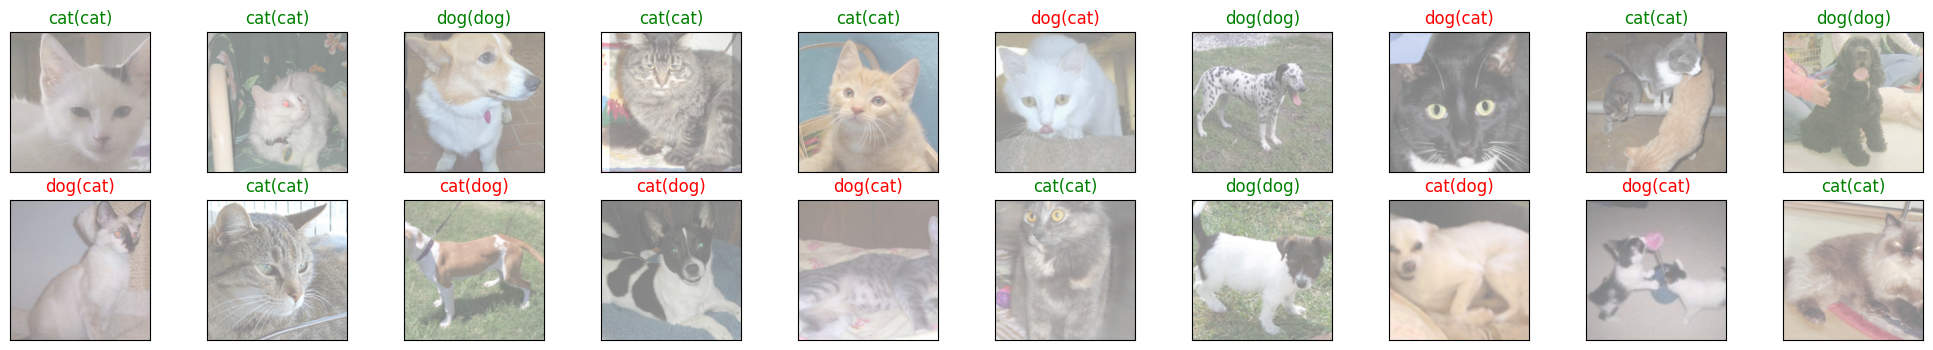

<Figure size 640x480 with 0 Axes>

In [20]:
# 개와 고양이 예측 결과 출력
classes = {0: 'cat', 1: 'dog'}   # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader)   # 테스트 데이터로더를 가져옵니다.
images,labels=next(dataiter)   # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옵니다.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])   # ①
    plt.imshow(im_convert(images[idx]))   # 이미지 출력을 위해 코드 5-20에서 정의한 im_convert 함수 적용
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))   # ②
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)   # ③


① add_subplot은 한 화면에 여러 개의 이미지를 담기 위해 사용한다

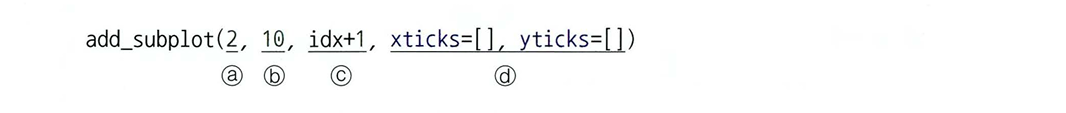

a. 첫 번째 파라미터 : 행의 수를 의미하는데, 이미지를 두 줄로 출력

b. 두 번째 파라미터 : 열의 수를 의미하는데, 한 줄에 열 개의 이미지를 출력

c. 세 번째 파라미터 : 인덱스를 의미하는데, 행과 열을 기준으로 순차적으로 이미지를 출력

d. 네 번째 파라미터 : tick을 삭제하겠다는 의미

→x축, y축 틱 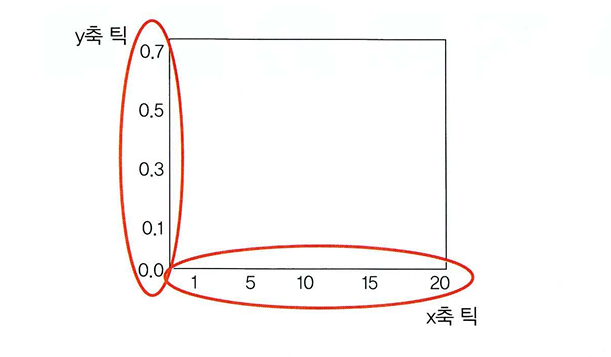

---



② classes[preds[idx].item()]은 0과 1 중 어떤 값을 갖는지 판별하겠다는 의미

→ classes[preds[idx].item()] 값이 0이면 고양이, 1이면 개로 출력

③ figure 안의 서브플롯의 위치를 조정할 때 사용한다

→ left / bottom / right / top으로 이미지 위치를 조정하고, hspace / wspace를 사용해 서브플롯 간의 간격을 조정한다

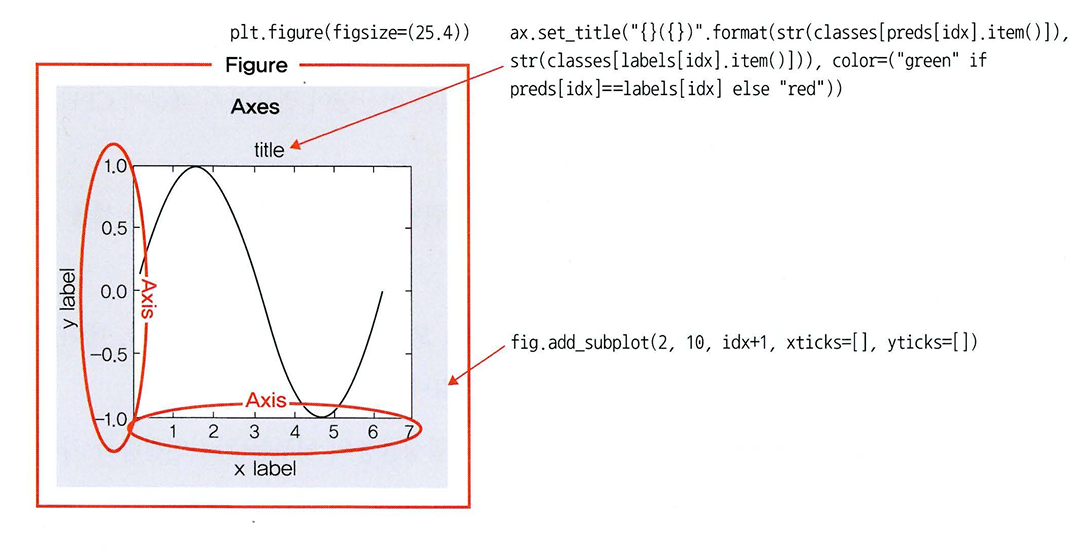

# 5.3.2 미세 조정 기법

- 미세 조정 기법 : 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식

→ 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것

- 미세 조정 기법의 전략 ( 데이터셋의 크기와 사전 훈련된 모델에 따라 결정 )
  - **데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우** : 모델 전체를 재학습시킨다.
  - **데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우** : 합성곱층의 뒷부분과 데이터 분류기를 학습시킨다.
  - **데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우** : 합성곱층의 일부분과 데이터 분류기를 학습시킨다.
  - **데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우** : 데이터 분류기만 학습시킨다.

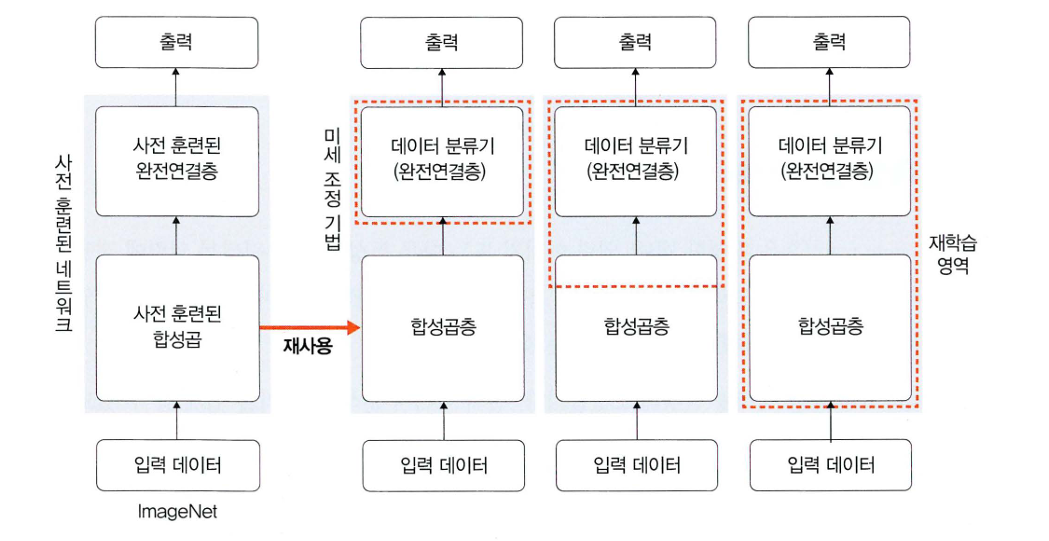